# Homework for Week 6

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [2]:
df = pd.read_csv("car_fuel_efficiency.csv")
df = df.fillna(0)
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"]
del df_test["fuel_efficiency_mpg"]

In [4]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dicts)

X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [5]:
dt = DecisionTreeRegressor(max_depth=1)  
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [6]:
# Q1: Train decision tree with max_depth=1
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [7]:
# Q2 
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [8]:
# Q2: Random Forest RMSE
y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.4596


RMSE stops improving at n_estimators = 180
Minimum RMSE (3 dp): 0.442


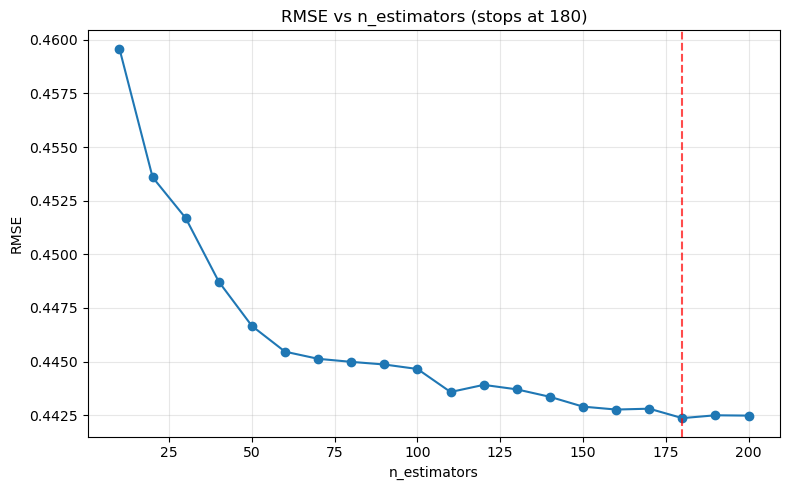

In [9]:
# Q3: When does RMSE stop improving? (3 decimal precision)
results = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    rmse = root_mean_squared_error(y_val, rf.predict(X_val))
    results.append((n, rmse))

df_scores = pd.DataFrame(results, columns=["n_estimators", "rmse"])
df_scores["rmse_3dp"] = df_scores["rmse"].round(3)

min_rmse = df_scores["rmse_3dp"].min()
stop_n = int(df_scores[df_scores["rmse_3dp"] == min_rmse]["n_estimators"].iloc[0])

print(f"RMSE stops improving at n_estimators = {stop_n}")
print(f"Minimum RMSE (3 dp): {min_rmse}")

plt.figure(figsize=(8, 5))
plt.plot(df_scores.n_estimators, df_scores.rmse, marker="o")
plt.axvline(stop_n, color="red", linestyle="--", alpha=0.7)
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.title(f"RMSE vs n_estimators (stops at {stop_n})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Q4: Best max_depth based on mean RMSE
results = []
max_depth_values = [10, 15, 20, 25]

for md in max_depth_values:
    rmses = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        rmse = root_mean_squared_error(y_val, rf.predict(X_val))
        rmses.append(rmse)
    
    mean_rmse = np.mean(rmses)
    results.append((md, mean_rmse))
    print(f"max_depth={md}, mean RMSE={mean_rmse:.4f}")

best_md = min(results, key=lambda x: x[1])[0]
print(f"\nBest max_depth: {best_md}")

KeyboardInterrupt: 

In [ ]:
# Q5: Feature importance
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'feature': dv.get_feature_names_out(),
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

target_features = ['vehicle_weight', 'horsepower', 'acceleration', 'engine_displacement']
filtered = importance_df[importance_df['feature'].isin(target_features)]

print("Feature Importances:")
print(filtered)
print(f"\nMost important: {filtered.iloc[0]['feature']}")

Feature Importances:
                feature  importance
13       vehicle_weight    0.959150
6            horsepower    0.015998
0          acceleration    0.011480
3   engine_displacement    0.003273

Most important: vehicle_weight


In [ ]:
# Q6: XGBoost with different eta values
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Train with eta=0.3
print("Training with eta=0.3:")
xgb_params['eta'] = 0.3
model_03 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=20)
rmse_03 = root_mean_squared_error(y_val, model_03.predict(dval))

# Train with eta=0.1
print("\nTraining with eta=0.1:")
xgb_params['eta'] = 0.1
model_01 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=20)
rmse_01 = root_mean_squared_error(y_val, model_01.predict(dval))

# Compare
print(f"\neta=0.3: RMSE = {rmse_03:.4f}")
print(f"eta=0.1: RMSE = {rmse_01:.4f}")
print(f"Best eta: {0.3 if rmse_03 < rmse_01 else 0.1}")

Training with eta=0.3:
[0]	train-rmse:1.81393	val-rmse:1.85444
[10]	train-rmse:0.37115	val-rmse:0.43896
[20]	train-rmse:0.33553	val-rmse:0.43376
[30]	train-rmse:0.31475	val-rmse:0.43752
[40]	train-rmse:0.30202	val-rmse:0.43968
[50]	train-rmse:0.28456	val-rmse:0.44140
[60]	train-rmse:0.26768	val-rmse:0.44290
[70]	train-rmse:0.25489	val-rmse:0.44531
[80]	train-rmse:0.24254	val-rmse:0.44689
[90]	train-rmse:0.23193	val-rmse:0.44839
[99]	train-rmse:0.21950	val-rmse:0.45018

Final RMSE with eta=0.3: 0.4502

Training with eta=0.1:
[0]	train-rmse:2.28944	val-rmse:2.34561
[10]	train-rmse:0.91008	val-rmse:0.94062
[20]	train-rmse:0.48983	val-rmse:0.53064
[30]	train-rmse:0.38342	val-rmse:0.44289
[40]	train-rmse:0.35343	val-rmse:0.42746
[50]	train-rmse:0.33998	val-rmse:0.42498
[60]	train-rmse:0.33054	val-rmse:0.42456
[70]	train-rmse:0.32202	val-rmse:0.42503
[80]	train-rmse:0.31667	val-rmse:0.42563
[90]	train-rmse:0.31059	val-rmse:0.42586
[99]	train-rmse:0.30419	val-rmse:0.42623

Final RMSE with eta